In [214]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import zscore
from scipy.special import expit
from pymc import do, observe
import lifelines
from lifelines import CoxPHFitter

In [216]:
hems_d = pd.read_csv('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/5-modeling-weather-v-outcome/hems_d.csv', index_col=False)
d_window = hems_d.dropna(axis=0, subset='both_hems_minima_window').copy()
d_window = d_window.dropna(axis=0, subset='sir_consciousness_level').copy()

data = d_window

n_samples = len(data)

SAMPLE = np.arange(n_samples)

HEMS_MINIMA, TREATMENT =  pd.factorize(data['both_point_hems_minima'], sort=True)

SENDING_CENTER_IDX, SENDING_CENTER =  pd.factorize(data['sir_icu_name'], sort=True)
RECEIVING_CENTER_IDX, RECEIVING_CENTER = pd.factorize(data['tertiary_center'], sort=True)

MONTH_IDX, MONTH = pd.factorize(data['utc_month'], sort=True)
DAY_IDX, DAY = pd.factorize(data['utc_day'], sort=True)
HOUR_IDX, HOUR = pd.factorize(data['admission_hour_utc'], sort=True)
DAYLIGHT_IDX, DAYLIGHT = pd.factorize(data['sending_daylight'], sort=True)
AFTERHOURS_IDX, AFTERHOURS = pd.factorize(data['icu_admission_afterhours'], sort=True)

DX_IDX, DX = pd.factorize(data['DX'], sort=True)

AGE_STD = zscore(data['age'])
FEMALE_IDX, FEMALE = pd.factorize(data['sex_female'], sort=True)

CONCIOUSNESS_IDX, CONCIOUSNESS = pd.factorize(data['sir_consciousness_level'], use_na_sentinel=True, sort=True)
CONCIOUSNESS_IDX = np.ma.masked_equal(CONCIOUSNESS_IDX, -1)

data['discharged'] = 1
data['age_std'] = AGE_STD

### Cox PH model: time to discharge from primary ICU

In [241]:
cph = CoxPHFitter()
cph.fit(data, duration_col='sir_total_time', event_col='discharged', cluster_col="sir_icu_name", formula="both_hems_minima_window + DX + icu_admission_nighttime")

<lifelines.CoxPHFitter: fitted with 2830 total observations, 0 right-censored observations>

In [243]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2830 total observations, 0 right-censored observations>
             duration col = 'sir_total_time'
                event col = 'discharged'
              cluster col = 'sir_icu_name'
          robust variance = True
      baseline estimation = breslow
   number of observations = 2830
number of events observed = 2830
   partial log-likelihood = -19486.48
         time fit was run = 2024-05-06 21:12:04 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
both_hems_minima_window[T.True] -0.00      1.00      0.05           -0.10            0.10                0.90                1.10
DX[T.AIS]                        0.99      2.70      0.13            0.73            1.25                2.08                3.51
DX[T.ASAH]                       1.16      3.20      0.09            0.99            1.34                2.69                3.81
DX[T.AVM]                        0.59      1.81      0.15            0.29            0.89                1.34                2.44
DX[T.CFX]                       -0.04      0.96      0.10           -0.24            0.16                0.79                1.17
DX[T.CVT]                        0.54      1.71      0.27            0.02            1.06                1.02                2.89
DX[T.ENC]                        0.32      1.37      0.22           -0.11            0.75                0.89                2.11
DX[T.HC]                         0.97      2.63      0.18            0.62            1.31                1.86                3.72
DX[T.ICH]                        0.89      2.44      0.06            0.78            1.00                2.18                2.72
DX[T.SDH]                        0.53      1.70      0.10            0.32            0.73                1.38                2.08
DX[T.SEP]                       -1.20      0.30      0.45           -2.09           -0.31                0.12                0.73
DX[T.TBI]                        0.52      1.69      0.06            0.41            0.64                1.50                1.90
DX[T.TUM]                        0.78      2.17      0.20            0.38            1.17                1.46                3.23
icu_admission_nighttime         -0.09      0.92      0.04           -0.16           -0.01                0.85                0.99

                                 cmp to     z      p  -log2(p)
covariate                                                     
both_hems_minima_window[T.True]    0.00 -0.06   0.96      0.07
DX[T.AIS]                          0.00  7.42 <0.005     42.96
DX[T.ASAH]                         0.00 13.04 <0.005    126.70
DX[T.AVM]                          0.00  3.87 <0.005     13.14
DX[T.CFX]                          0.00 -0.39   0.70      0.52
DX[T.CVT]                          0.00  2.02   0.04      4.54
DX[T.ENC]                          0.00  1.44   0.15      2.74
DX[T.HC]                           0.00  5.47 <0.005     24.38
DX[T.ICH]                          0.00 16.01 <0.005    189.33
DX[T.SDH]                          0.00  5.09 <0.005     21.38
DX[T.SEP]                          0.00 -2.65   0.01      6.96
DX[T.TBI]                          0.00  8.91 <0.005     60.72
DX[T.TUM]                          0.00  3.84 <0.005     12.97
icu_admission_nighttime            0.00 -2.35   0.02      5.74
---
Concordance = 0.62
Partial AIC = 39000.96
log-likelihood ratio test = 362.69 on 14 df
-log2(p) of ll-ratio test = 226.05

Partial effect of diagnostic group on time to discharge

<Axes: >

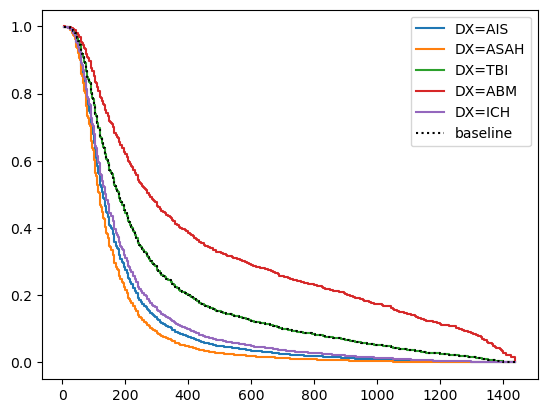

In [244]:
cph.plot_partial_effects_on_outcome(covariates='DX', values=["AIS", "ASAH", "TBI", "ABM", "ICH"])

Partial effect of HEMS minima met on time to discharge

<Axes: >

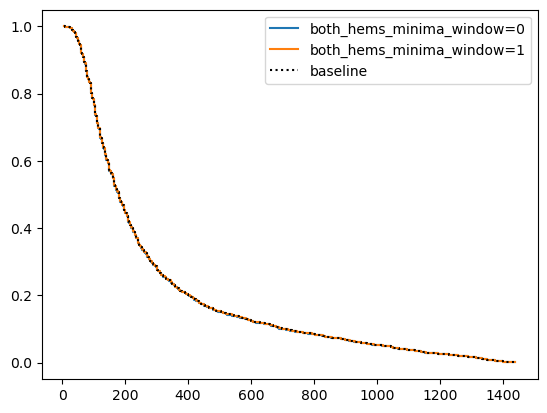

In [232]:
cph.plot_partial_effects_on_outcome(covariates='both_hems_minima_window', values=[0,1])

### Cox PH model: 365-day mortality

In [262]:
data['days_alive_365'] = data.days_alive.fillna(365).clip(upper=365)
cph = CoxPHFitter()
cph.fit(data, duration_col='days_alive_365', event_col='d365', cluster_col="sir_icu_name", formula="both_hems_minima_window + DX + age_std + icu_admission_nighttime + sir_consciousness_level")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2830 total observations, 2267 right-censored observations>
             duration col = 'days_alive_365'
                event col = 'd365'
              cluster col = 'sir_icu_name'
          robust variance = True
      baseline estimation = breslow
   number of observations = 2830
number of events observed = 563
   partial log-likelihood = -4186.00
         time fit was run = 2024-05-06 21:18:37 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
both_hems_minima_window[T.True]           -0.04      0.96      0.13           -0.30            0.22                0.74                1.25
DX[T.AIS]                                  0.49      1.63      0.29           -0.08            1.05                0.92                2.87
DX[T.ASAH]                                 0.06      1.06      0.17           -0.28            0.39                0.76                1.48
DX[T.AVM]                                  0.11      1.12      0.61           -1.08            1.31                0.34                3.71
DX[T.CFX]                                  0.38      1.46      0.23           -0.07            0.83                0.93                2.28
DX[T.CVT]                                  0.21      1.24      0.67           -1.10            1.53                0.33                4.62
DX[T.ENC]                                 -0.05      0.95      0.91           -1.84            1.74                0.16                5.72
DX[T.HC]                                   0.63      1.88      0.38           -0.12            1.38                0.88                3.98
DX[T.ICH]                                  0.39      1.48      0.17            0.06            0.73                1.07                2.07
DX[T.SDH]                                 -0.14      0.87      0.24           -0.61            0.33                0.54                1.39
DX[T.SEP]                                -11.78      0.00      0.64          -13.03          -10.53                0.00                0.00
DX[T.TBI]                                 -0.37      0.69      0.16           -0.69           -0.05                0.50                0.95
DX[T.TUM]                                  1.59      4.90      0.24            1.12            2.06                3.07                7.81
age_std                                    0.62      1.87      0.06            0.51            0.74                1.66                2.10
icu_admission_nighttime                   -0.27      0.76      0.09           -0.44           -0.10                0.64                0.90
sir_consciousness_level[T.II (GCS 7-12)]   1.00      2.72      0.12            0.76            1.24                2.14                3.46
sir_consciousness_level[T.III (GCS 6)]     1.50      4.50      0.13            1.25            1.76                3.49                5.80
sir_consciousness_level[T.IV (GCS 5)]      1.34      3.84      0.16            1.02            1.67                2.79                5.29
sir_consciousness_level[T.V (GCS ≤4)]      1.90      6.69      0.12            1.67            2.13                5.29                8.46

                                          cmp to      z      p  -log2(p)
covariate                                                               
both_hems_minima_window[T.True]             0.00  -0.31   0.76      0.40
DX[T.AIS]                                   0.00   1.68   0.09      3.43
DX[T.ASAH]                                  0.00   0.33   0.74      0.44
DX[T.AVM]                                   0.00   0.19   0.85      0.23
DX[T.CFX]                                   0.00   1.65   0.10      3.32
DX[T.CVT]                                   0.00   0.32   0.75      0.41
DX[T.ENC]                    

Partial effect of DX group on time to death.

<Axes: >

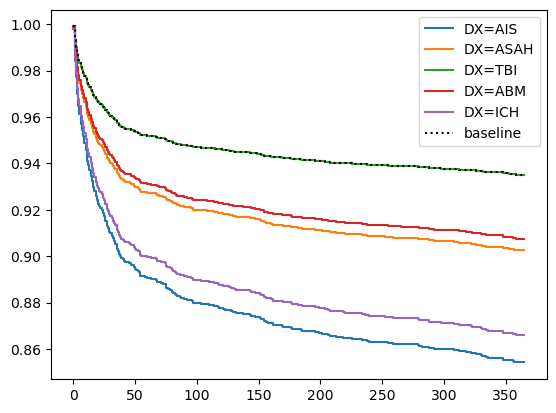

In [263]:
cph.plot_partial_effects_on_outcome(covariates='DX', values=["AIS", "ASAH", "TBI", "ABM", "ICH"])

Partial effect of being admitted at night (22-07) vs not. I.e. seems to be better to be admitted at night...

<Axes: >

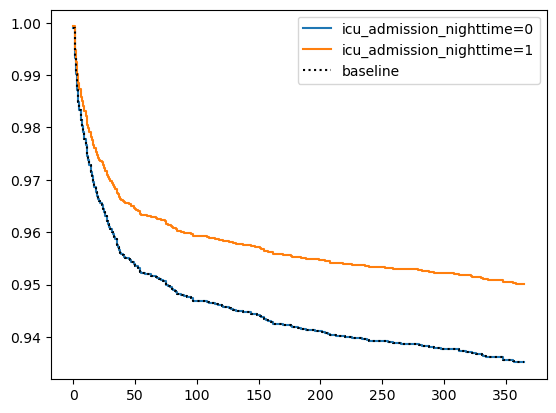

In [264]:
cph.plot_partial_effects_on_outcome(covariates='icu_admission_nighttime', values=[0,1])

Partial effect of HEMS minima met vs not. Non significant win for HEMS minima being met.

(<Axes: >,)

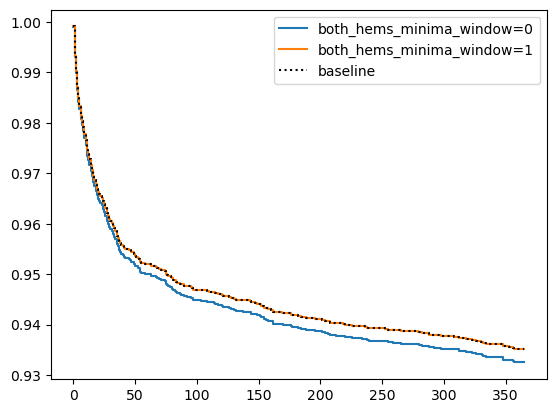

In [265]:
cph.plot_partial_effects_on_outcome(covariates='both_hems_minima_window', values=[0,1]),